## Decision models homework 4

In [1]:
# Beyonce
import jax

# if i had a pet horse
import numpy as np

# that uncle that nobody likes but everyone puts up with because he has money
import matplotlib.pyplot as plt

# your cousin with down syndrome
import random

In [2]:
class Params(object):
    def __init__(
        self,
        BuyPrice=50,
        SalePrice=75,
        ExcessPrice=15,
        salesMean=500,
        salesStd=75,
        OrderQ=550,
        n_trials=10000,
        min_orderQ = 400,
        max_orderQ = 600,
    ):
        self.BuyPrice = BuyPrice
        self.SalePrice = SalePrice
        self.ExcessPrice = ExcessPrice
        self.salesMean = salesMean
        self.salesStd = salesStd
        self.OrderQ = OrderQ
        self.n_trials = n_trials
        self.min_orderQ = min_orderQ
        self.max_orderQ = max_orderQ

### Trivial/Naive solution. We do it this way to test the speed, and compare the time to better methods

In [3]:
args = Params(n_trials=100000)
sales_list, profit_list = [], []
sanity_check = []
for i in range(args.n_trials):
    # compute demand
    demand = int(random.normalvariate(args.salesMean, args.salesStd))

    # costs
    cost = args.OrderQ*args.BuyPrice
    
    # revenue
    
    season_sales = min(demand, args.OrderQ)
    post_season_sales = max(0, args.OrderQ-season_sales)
    revenue = post_season_sales*args.ExcessPrice + season_sales*args.SalePrice
    sales_list.append(season_sales)
    
    sanity_check.append(season_sales+post_season_sales)
    
    # profit
    profit_list.append(revenue-cost)
    
profit_list = np.array(profit_list)
sales_list = np.array(sales_list)

In [4]:
print('average total sales: sanity check', sum(sanity_check)/len(sanity_check))

average total sales: sanity check 550.0


### A) Distribution of total profit

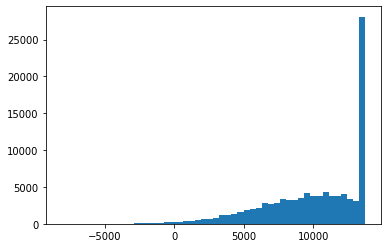

In [5]:
plt.hist(profit_list, bins=50)
plt.show()

### B) Total profit mean

In [6]:
print('Mean profit', sum(profit_list)/len(profit_list))

Mean profit 10037.8672


In [7]:
max(profit_list)

13750

### C) Probability of loss

In [8]:
print('Probability of loss', (np.array(profit_list)>0).mean())

Probability of loss 0.99133


### D) Simulate order quantities between two values

In [40]:
%%timeit
args = Params()
profit_array = []
sales_list, profit_list = [], []

min_orderQ = 400
max_orderQ = 600
orderQ_array = np.arange(min_orderQ, max_orderQ)
for orderQ in orderQ_array:
    profit_list = []
    for i in range(args.n_trials):
        # compute demand
        demand = int(random.normalvariate(args.salesMean, args.salesStd))

        # costs
        cost = orderQ*args.BuyPrice

        # revenue
        season_sales = min(demand, orderQ)
        post_season_sales = max(0, orderQ-season_sales)
        revenue = post_season_sales*args.ExcessPrice + season_sales*args.SalePrice
        sales_list.append(season_sales)

        sanity_check.append(season_sales+post_season_sales)

        # profit
        profit_list.append(revenue-cost)
    profit_array.append(profit_list)
profit_array = np.array(profit_array)

5.22 s ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
mean_profit = profit_array.mean(axis=1)

In [15]:
max_quantity = orderQ_array[np.argmax(mean_profit)]
print(max_quantity)

489


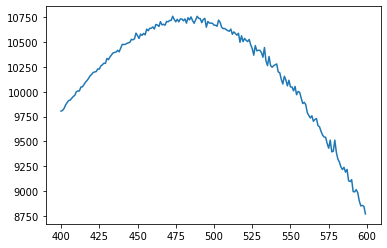

In [16]:
plt.plot(orderQ_array, mean_profit)
plt.show()

# 1) but better
The simulation for 10,000 trials and every integer order quantity between 400 and 600 took 5 seconds total. Absolutely pathetic.

In [17]:
class JaxParams(object):
    def __init__(
        self,
        BuyPrice=50,
        SalePrice=75,
        ExcessPrice=15,
        salesMean=500,
        salesStd=75,
        OrderQ=550,
        n_trials=10000,
        min_orderQ = 400,
        max_orderQ = 600,
    ):
        self.BuyPrice = jax.numpy.float16(BuyPrice)
        self.SalePrice = jax.numpy.float16(SalePrice)
        self.ExcessPrice = jax.numpy.float16(ExcessPrice)
        self.salesMean = jax.numpy.float16(salesMean)
        self.salesStd = jax.numpy.float16(salesStd)
        self.OrderQ = jax.numpy.float16(OrderQ)
        self.n_trials = n_trials
        self.min_orderQ = min_orderQ
        self.max_orderQ = max_orderQ

Entropy is handled by passing and iterating PRNG state, which allows us to fork the PRNG state into new PRNGs for use with parallel stochastic generation

In [19]:
KEY = jax.random.PRNGKey(1)

# Use half precision for more efficient resource use
# shape is (10000, 1) to deal with batched processing later on
args = Params()
orderQ_array = jax.numpy.arange(args.min_orderQ, args.max_orderQ, dtype=jax.numpy.int16)

/data/home/will/.conda/envs/will-gpu/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [20]:
# jax primatives 
from jax import lax

args = JaxParams()
orderQ_array = jax.numpy.arange(args.min_orderQ, args.max_orderQ, dtype=jax.numpy.float16)

# Jit compiled functions do not have to be composed of Jax primatives if they are composed of jax.numpy transformations - they will be tracable either way
# I just wanted to do it this way to see if it was faster, and the problems are usually too hard to write with primatives. It was not faster :(
@jax.jit
def compute_profit(sn_val, orderQ=orderQ_array[0]):
    demand = lax.add(    
        lax.mul(
            args.salesStd, 
            sn_val
        ),
        
        args.salesMean

    ).astype(jax.numpy.float16)

#     cost
    cost = lax.mul(
        orderQ,
        args.BuyPrice,
    )

    # revenue
    season_sales = jax.numpy.minimum(demand, orderQ)
    post_season_sales = jax.numpy.maximum(0, orderQ-season_sales)
    
    revenue = lax.add(
        lax.mul(
            post_season_sales,
            args.ExcessPrice,
        ),
        
        lax.mul(
            season_sales, 
            args.SalePrice,
        )
    )
    
    # this just prints the semantic parameter information and does not "vectorize print"
    print(revenue-cost)
    
    return revenue-cost


One dimensional vectorized mapping over tensor of PRNG values

In [21]:
@jax.jit
def sim_1d(sn_tensor):
    return jax.vmap(compute_profit)(sn_tensor)

In [24]:
%%timeit
random_tensor = jax.random.normal(key=KEY, shape=(10000, 1), dtype=jax.numpy.float16)
sim_1d(random_tensor).block_until_ready()

415 µs ± 30 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Two dimensional vectorized mapping over tensor of PRNG values and tensor of possible order quantities

In [25]:
@jax.jit
def sim_2d(sn_tensor, orderQ_tensor):
    return jax.vmap(compute_profit, (0, None), 0)(sn_tensor, orderQ_tensor)

In [31]:
%%timeit
random_tensor = jax.random.normal(key=KEY, shape=(10000, 1), dtype=jax.numpy.float16)
sim_2d(random_tensor, orderQ_array).block_until_ready()

686 µs ± 5.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


680 microseconds is 0.00068 seconds

In [42]:
5/0.00068

7352.941176470587

For the exact same task, this is almost 3 orders of magnitude faster
Note: NO GPU WAS USED HERE, this is ENTIRELY done on the CPU. On a decent GPU, it would not be the slightest bit unreasonable to expect an **additional** order of magnitude efficiency gain on top of this

Jax dispatches tensor operations asynchronously, and immediately returns a preallocated output tensor. A common "gotcha" in Jax is to use %%timeit, which will only time the asynchronous dispatch stage, and not execution. We solve this by using block_until_ready() which is a function mostly used to solve this issue. Waiting for computations to complete before returning the tensor is usually slower.

# 2)

In [33]:
class Params2(object):
    def __init__(
        self,
        MinPrice = 18.95,
        MaxPrice = 26.95,
        MeanPrice = 24.95,
        UCMax = 15,
        UCMin = 12,
        FCMean = 30000,
        FCStd = 5000,
        n_trials = 10000,
    ):
        self.MinPrice = MinPrice
        self.MaxPrice = MaxPrice
        self.MeanPrice = MeanPrice
        self.UCMax = UCMax
        self.UCMin = UCMin
        self.FCMean = FCMean
        self.FCStd = FCStd
        self.n_trials = n_trials

In [34]:
args = Params2()

def compute_profit(args):
    sales_price = np.random.triangular(args.MinPrice, args.MeanPrice, args.MaxPrice, 1)[0]
    random_factor = 10*np.random.normal()
    sales = 10000- 250*sales_price + random_factor
    
    # costs
    random_unit_cost = np.random.uniform(args.UCMin, args.UCMax)
    random_cost_factor = args.FCStd*np.random.normal() + args.FCMean
    total_cost = random_cost_factor + sales*random_unit_cost
    
    return sales*sales_price - total_cost

In [35]:
profit = []
for i in range(args.n_trials):
    profit.append(compute_profit(args))
profit = np.array(profit)

#### A)
Profit appears to be normally distributed

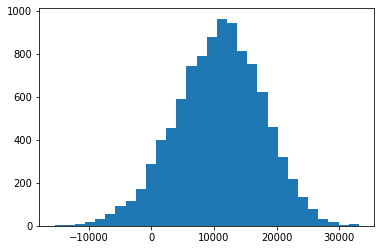

In [36]:
plt.hist(profit, bins=30)
plt.show()

#### B)
~10,700$

In [37]:
profit.mean()

10796.615558510008

#### C)
~6%

In [38]:
(profit<0).mean()

0.0632

#### D)
~ -15,000$

In [39]:
profit.min()

-15438.781413351375